In [1]:
from ast import literal_eval
import numpy as np
import pandas as pd

from gensim import corpora
from gensim.models import CoherenceModel, LdaMulticore
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

/Users/ethancy/fb_crawling/venv/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
posts = pd.read_csv("./data/refined/post_with_seg.csv")
comments_by_author = pd.read_csv("./data/refined/comments_by_author_with_seg.csv")
posts['word_list'] = posts['word_list'].apply(literal_eval)
comments_by_author['word_list'] = comments_by_author['word_list'].apply(literal_eval)
comments_by_author['phase'] = comments_by_author['post_url'].map(posts.set_index('post_url')['phase'])
comments_by_author['fanpage'] = comments_by_author['post_url'].map(posts.set_index('post_url')['fanpage'])

In [3]:
#選擇斷詞後，文字長度大於1的詞
posts['word_list'] = posts['word_list'].apply(lambda x:[i for i in x if len(i)>1 ])
comments_by_author['word_list'] = comments_by_author['word_list'].apply(lambda x:[i for i in x if len(i)>1 ])


# 全期間

## 貼文LDA模型

In [4]:
# prepare LDA configuration
post_id2word = corpora.Dictionary(posts['word_list']) # Create Dictionary
post_texts = posts['word_list'] # Create Corpus
post_corpus = [post_id2word.doc2bow(post_texts) for post_texts in post_texts] # Term Document Frequency

In [5]:
%%time
num_topics = 5
# Build LDA model
post_lda_model = LdaMulticore(corpus=post_corpus,
                       id2word=post_id2word,
                       iterations=500,
                       num_topics=num_topics,
                       passes=10)

# Print the Keyword in the 5 topics
pprint(post_lda_model.print_topics())
doc_lda = post_lda_model[post_corpus]

[(0,
  '0.088*"三倍券" + 0.042*"振興券" + 0.016*"振興" + 0.012*"懶人包" + 0.009*"加碼" + '
  '0.008*"上路" + 0.008*"綁定" + 0.008*"預購" + 0.007*"優惠" + 0.007*"武漢肺炎"'),
 (1,
  '0.072*"三倍券" + 0.018*"蘇貞昌" + 0.016*"消費券" + 0.016*"振興" + 0.015*"振興券" + '
  '0.010*"優惠" + 0.009*"民眾" + 0.008*"超商" + 0.008*"行政院" + 0.007*"郵局"'),
 (2,
  '0.048*"振興券" + 0.032*"消費券" + 0.028*"三倍券" + 0.021*"郵局" + 0.010*"振興" + '
  '0.009*"馬英九" + 0.008*"當年" + 0.008*"蘇貞昌" + 0.008*"發放" + 0.008*"經濟"'),
 (3,
  '0.098*"三倍券" + 0.022*"振興" + 0.021*"振興券" + 0.014*"消費" + 0.013*"使用" + '
  '0.012*"講座" + 0.009*"上路" + 0.009*"經濟" + 0.007*"現金" + 0.007*"消費券"'),
 (4,
  '0.088*"三倍券" + 0.030*"振興" + 0.015*"消費券" + 0.013*"振興券" + 0.011*"預購" + '
  '0.010*"政府" + 0.010*"消費" + 0.007*"蔡英文" + 0.007*"經濟" + 0.006*"馬英九"')]
CPU times: user 3.54 s, sys: 401 ms, total: 3.94 s
Wall time: 9.12 s


### 計算模型複雜性及一致性

In [6]:
# Compute Perplexity
print('\nPerplexity: ', post_lda_model.log_perplexity(post_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_model = CoherenceModel(model=post_lda_model, texts=posts['word_list'], dictionary=post_id2word, coherence='u_mass')
coherence_lda_model = coherence_model_lda_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model)



Perplexity:  -7.043931735096418

Coherence Score:  -5.5069972037713555


In [7]:
# 把lda的結果放回去posts 表格中
posts['post_topic'] = [i for i in doc_lda]
temp = posts[['post_url','post_topic']].set_index('post_url')['post_topic'].explode().reset_index()
temp['topic'] = temp['post_topic'].apply(lambda x: x[0])
temp['prob'] = temp['post_topic'].apply(lambda x: x[1])
temp = temp.set_index(['post_url','topic'])['prob'].unstack(-1).add_prefix('prob_post_topic_').reset_index().fillna(0)

posts['most_likely_post_topic'] = posts['post_topic'].apply(lambda x:[j[0] for j in x if j[1] == max([i[1] for i in x])][0])
posts = pd.merge(posts, temp, on='post_url').drop('post_topic',axis='columns')
posts.head()

,post_url,post_time,post_content,link_title,total_reaction,Like,Haha,Angry,Wow,Love,...,sentiment_pos,sentiment_neg,sentiment_score,sentiment_score_filled,most_likely_post_topic,prob_post_topic_0,prob_post_topic_1,prob_post_topic_2,prob_post_topic_3,prob_post_topic_4
0,https://www.facebook.com/YahooTWNews/posts/330...,2020-05-07 00:00:00,因為消費券是馬政府當年的政策，因為發現金是國民黨黨團今日的主張，為了這口氣蔡總統是非常不樂意...,「你搞得我好亂啊」的紓困政策—發現金或消費券有這麼難？,276,177,53,44,0,0,...,0,4,0.0,0.000000,1,0.000000,0.981256,0.000000,0.000000,0.000000
1,https://www.facebook.com/appledaily.tw/posts/1...,2020-07-01 00:00:00,準備好去台南進行報復性消費了三倍券預購懶人包4大超商今開跑！只限7天送購物金、咖啡半價拉客 ...,三倍券上路最大禮！來台南消費市府灑血本送「600萬附車位公寓」,18,15,3,0,0,0,...,2,0,1.0,1.000000,4,0.000000,0.000000,0.000000,0.000000,0.967617
2,https://www.facebook.com/news.ebc/posts/435323...,2020-06-01 00:00:00,YA！這次錢真的來了！要領要快 振興券 紓困補助 武漢肺炎,3000元振興券來了！這天起上路 領取方法一次看懂,1400,1100,84,164,0,0,...,0,0,NaN,0.503675,0,0.554061,0.018361,0.390175,0.018734,0.018669
3,https://www.facebook.com/news.ebc/posts/457278...,2020-06-30 00:00:00,天啊！準備好去搶錢錢了嗎？ 三倍券,3000元三倍券明天來了！怎麼領最賺？方式一次秒懂,978,891,0,45,17,0,...,1,0,1.0,1.000000,3,0.022548,0.022501,0.022578,0.909479,0.022895
4,https://www.facebook.com/news.ebc/posts/473005...,2020-07-21 00:00:00,天啊！準備好開搶了嗎？ 三倍券 超商,三倍券第二輪明天開搶！4大超商最新優惠一次看,589,569,5,0,0,5,...,1,0,1.0,1.000000,1,0.018527,0.925333,0.018817,0.018505,0.018818


<AxesSubplot:xlabel='most_likely_post_topic', ylabel='sentiment_score_filled'>

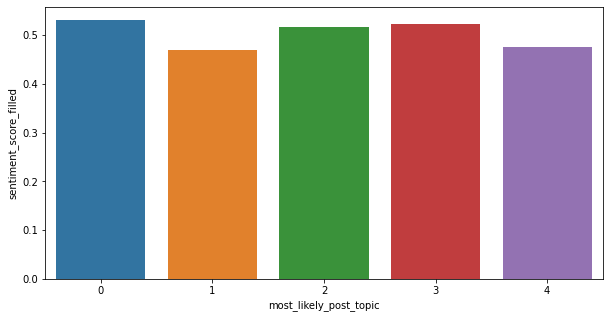

In [8]:
plt.subplots(figsize=(10,5))
temp = posts.groupby('most_likely_post_topic')['sentiment_score_filled'].mean().sort_values().reset_index()
sns.barplot(x='most_likely_post_topic',y='sentiment_score_filled',data=temp)

In [9]:
# fanpage x topic

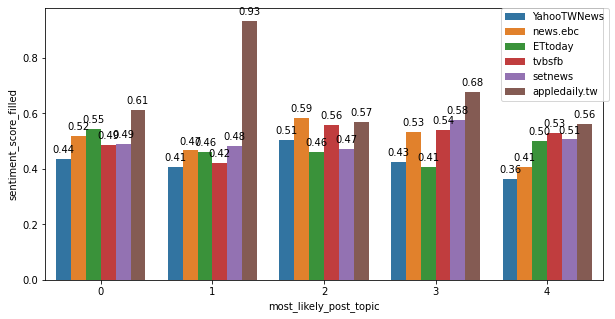

In [10]:
plt.subplots(figsize=(10,5))
temp = posts.groupby(['fanpage','most_likely_post_topic'])['sentiment_score_filled'].mean().sort_values().reset_index()
plot = sns.barplot(x='most_likely_post_topic',y='sentiment_score_filled',hue="fanpage",data=temp)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

## 回應

In [11]:
# make most likely post topic available in comments
comments_by_author['most_likely_post_topic'] = comments_by_author['post_url'].map(posts.set_index('post_url')['most_likely_post_topic'])

In [12]:
comment_word_threshold = 20 # 最少要在所有留言中出現幾次才納入分析
temp = comments_by_author.set_index(['post_url','author'])['word_list'].rename('word_count').explode()
val_count = pd.DataFrame(temp.value_counts())
val_count['word'] = val_count.index.values
val_count = val_count[(val_count['word'].apply(len)>1) & (val_count['word_count']>comment_word_threshold)]

### LDA模型: 各主題的貼文底下的留言又可分成幾個主題？

In [13]:
%%time
for post_topic in range(num_topics):
    print(f"post topic {post_topic}")
    post_topic_post_comments = comments_by_author[comments_by_author['most_likely_post_topic']==post_topic]
    
    print(f"{len(post_topic_post_comments)} comments from {post_topic_post_comments['post_url'].nunique()} posts" )
    
    comment_id2word = corpora.Dictionary(post_topic_post_comments['word_list'])
    comment_texts = post_topic_post_comments['word_list'] # Create Corpus
    comment_corpus = [comment_id2word.doc2bow(text) for text in comment_texts]# Term Document Frequency
    comment_lda_model = LdaMulticore(corpus=comment_corpus, id2word=comment_id2word, num_topics=3)
    # Print the Keyword in the 10 topics
    pprint(comment_lda_model.print_topics())
    doc_lda = comment_lda_model[comment_corpus]


post topic 0
30037 comments from 169 posts
[(0,
  '0.013*"政府" + 0.010*"消費" + 0.010*"小孩" + 0.007*"人民" + 0.006*"振興" + 0.006*"現金" '
  '+ 0.006*"政策" + 0.005*"直接" + 0.005*"出來" + 0.005*"民進黨"'),
 (1,
  '0.018*"政府" + 0.017*"振興" + 0.009*"人民" + 0.008*"經濟" + 0.008*"現金" + 0.007*"消費" '
  '+ 0.007*"現在" + 0.007*"振興券" + 0.006*"台灣" + 0.006*"發現金"'),
 (2,
  '0.014*"政府" + 0.009*"振興" + 0.008*"直接" + 0.007*"台灣" + 0.007*"麻煩" + 0.006*"知道" '
  '+ 0.006*"現在" + 0.005*"小孩" + 0.004*"使用" + 0.004*"民進黨"')]
post topic 1
23343 comments from 102 posts
[(0,
  '0.009*"現金" + 0.008*"消費" + 0.008*"人民" + 0.008*"振興" + 0.007*"直接" + 0.007*"三倍" '
  '+ 0.006*"政府" + 0.006*"台灣" + 0.005*"現在" + 0.005*"民進黨"'),
 (1,
  '0.015*"政府" + 0.009*"消費" + 0.008*"台灣" + 0.008*"郵局" + 0.008*"振興" + 0.008*"排隊" '
  '+ 0.007*"經濟" + 0.006*"現在" + 0.006*"麻煩" + 0.005*"直接"'),
 (2,
  '0.025*"政府" + 0.014*"振興" + 0.009*"人民" + 0.009*"排隊" + 0.008*"政策" + 0.006*"現在" '
  '+ 0.005*"振興券" + 0.005*"問題" + 0.005*"紓困" + 0.005*"消費券"')]
post topic 2
29736 comments from 93 posts
[

### LDA模型: 所有的留言下去分主題

In [14]:
%%time
num_topics=5
comment_id2word = corpora.Dictionary(comments_by_author['word_list'])
comment_texts = comments_by_author['word_list'] # Create Corpus
comment_corpus = [comment_id2word.doc2bow(text) for text in comment_texts]# Term Document Frequency
comment_lda_model = LdaMulticore(corpus=comment_corpus, id2word=comment_id2word, num_topics=num_topics)
pprint(comment_lda_model.print_topics(num_words=3))
doc_lda = comment_lda_model[comment_corpus]

[(0, '0.034*"振興" + 0.031*"政府" + 0.019*"現金"'),
 (1, '0.018*"政府" + 0.014*"小孩" + 0.010*"振興"'),
 (2, '0.013*"人民" + 0.010*"排隊" + 0.010*"政府"'),
 (3, '0.018*"政府" + 0.015*"民進黨" + 0.012*"消費"'),
 (4, '0.019*"消費券" + 0.017*"直接" + 0.012*"政府"')]
CPU times: user 9.01 s, sys: 1.95 s, total: 11 s
Wall time: 20 s


In [15]:
comments_by_author.head()

,post_url,author,comment,comment_no_ppl_tag,word_list,sentiment_pos,sentiment_neg,sentiment_score,sentiment_score_filled,phase,fanpage,most_likely_post_topic
0,https://www.facebook.com/ETtoday/posts/3150078...,Angel Lee,現在不促進觀光時候全民自主管理最安全先把那個錢省下來防疫工作不知道何時才會停止還有隔離醫療先...,現在不促進觀光時候全民自主管理最安全先把那個錢省下來防疫工作不知道何時才會停止還有隔離醫療先...,"[現在, 促進, 觀光, 時候, 全民, 自主, 管理, 安全, 省下來, 防疫, 工作, ...",11,9,0.550000,0.550000,1,ETtoday,2
1,https://www.facebook.com/ETtoday/posts/3150078...,Barry Shin,對於疫情處理好壞看看周圍亞洲各國你應該慶幸在台灣這篇留言串不知道什麼吊出很多群情激憤網民看起...,對於疫情處理好壞看看周圍亞洲各國你應該慶幸在台灣這篇留言串不知道什麼吊出很多群情激憤網民看起...,"[疫情, 處理, 好壞, 看看, 周圍, 亞洲, 慶幸, 台灣, 留言串, 吊出, 群情激憤...",5,9,0.357143,0.357143,1,ETtoday,2
2,https://www.facebook.com/ETtoday/posts/3150078...,Bau Bear,好事把消費留在國內,好事把消費留在國內,"[好事, 消費, 留在, 國內]",2,1,0.666667,0.666667,1,ETtoday,2
3,https://www.facebook.com/ETtoday/posts/3150078...,Benny Hsieh,賴宥蓁不然呢哪個建設和政策不花人民錢很正常,不然呢哪個建設和政策不花人民錢很正常,"[建設, 政策, 人民, 正常]",2,0,1.000000,1.000000,1,ETtoday,2
4,https://www.facebook.com/ETtoday/posts/3150078...,Bling Bling Lin,花菲菲撐過215國內觀光就不怕,花菲菲撐過215國內觀光就不怕,"[花菲菲, 國內, 觀光]",0,0,NaN,0.500000,1,ETtoday,2


In [16]:
temp

post_url                                                 author   
https://www.facebook.com/ETtoday/posts/3150078968361579  Angel Lee      現在
                                                         Angel Lee      促進
                                                         Angel Lee      觀光
                                                         Angel Lee      時候
                                                         Angel Lee      全民
                                                                      ... 
https://www.facebook.com/tvbsfb/posts/10157838344370933  黃瑋如            外交
                                                         黃瑋如            官員
                                                         黃瑋如            收入
                                                         黃瑋如          錦上添花
                                                         黃祥家            可惡
Name: word_count, Length: 1052523, dtype: object

In [17]:
# 把lda的結果放回去posts 表格中
comments_by_author['comment_topic'] = [i for i in doc_lda]
temp = comments_by_author[['post_url','author','comment_topic']].set_index(['post_url','author'])['comment_topic'].explode().reset_index()
temp['topic'] = temp['comment_topic'].apply(lambda x: x[0])
temp['prob'] = temp['comment_topic'].apply(lambda x: x[1])
temp = temp.set_index(['post_url','author','topic'])['prob'].unstack(-1).add_prefix('prob_comment_topic_').reset_index().fillna(0)

comments_by_author['most_likely_comment_topic'] = comments_by_author['comment_topic'].apply(lambda x:[j[0] for j in x if j[1] == max([i[1] for i in x])][0])
comments_by_author = pd.merge(comments_by_author, temp, on=['post_url','author']).drop('comment_topic',axis='columns')
comments_by_author.head()


,post_url,author,comment,comment_no_ppl_tag,word_list,sentiment_pos,sentiment_neg,sentiment_score,sentiment_score_filled,phase,fanpage,most_likely_post_topic,most_likely_comment_topic,prob_comment_topic_0,prob_comment_topic_1,prob_comment_topic_2,prob_comment_topic_3,prob_comment_topic_4
0,https://www.facebook.com/ETtoday/posts/3150078...,Angel Lee,現在不促進觀光時候全民自主管理最安全先把那個錢省下來防疫工作不知道何時才會停止還有隔離醫療先...,現在不促進觀光時候全民自主管理最安全先把那個錢省下來防疫工作不知道何時才會停止還有隔離醫療先...,"[現在, 促進, 觀光, 時候, 全民, 自主, 管理, 安全, 省下來, 防疫, 工作, ...",11,9,0.550000,0.550000,1,ETtoday,2,0,0.593829,0.389586,0.000000,0.000000,0.000000
1,https://www.facebook.com/ETtoday/posts/3150078...,Barry Shin,對於疫情處理好壞看看周圍亞洲各國你應該慶幸在台灣這篇留言串不知道什麼吊出很多群情激憤網民看起...,對於疫情處理好壞看看周圍亞洲各國你應該慶幸在台灣這篇留言串不知道什麼吊出很多群情激憤網民看起...,"[疫情, 處理, 好壞, 看看, 周圍, 亞洲, 慶幸, 台灣, 留言串, 吊出, 群情激憤...",5,9,0.357143,0.357143,1,ETtoday,2,4,0.000000,0.000000,0.000000,0.000000,0.962521
2,https://www.facebook.com/ETtoday/posts/3150078...,Bau Bear,好事把消費留在國內,好事把消費留在國內,"[好事, 消費, 留在, 國內]",2,1,0.666667,0.666667,1,ETtoday,2,0,0.662968,0.040676,0.040257,0.040601,0.215499
3,https://www.facebook.com/ETtoday/posts/3150078...,Benny Hsieh,賴宥蓁不然呢哪個建設和政策不花人民錢很正常,不然呢哪個建設和政策不花人民錢很正常,"[建設, 政策, 人民, 正常]",2,0,1.000000,1.000000,1,ETtoday,2,3,0.041062,0.040918,0.041360,0.836038,0.040620
4,https://www.facebook.com/ETtoday/posts/3150078...,Bling Bling Lin,花菲菲撐過215國內觀光就不怕,花菲菲撐過215國內觀光就不怕,"[花菲菲, 國內, 觀光]",0,0,NaN,0.500000,1,ETtoday,2,4,0.053135,0.051856,0.050255,0.050467,0.794288


<AxesSubplot:xlabel='most_likely_post_topic', ylabel='sentiment_score_filled'>

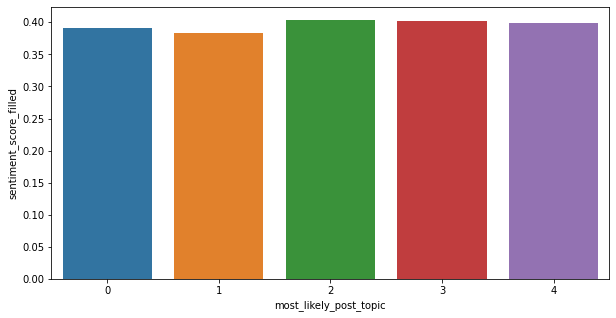

In [18]:
# by post topic
plt.subplots(figsize=(10,5))
temp = comments_by_author.groupby('most_likely_post_topic')['sentiment_score_filled'].mean().sort_values().reset_index()
sns.barplot(x='most_likely_post_topic',y='sentiment_score_filled',data=temp)

<AxesSubplot:xlabel='most_likely_comment_topic', ylabel='sentiment_score_filled'>

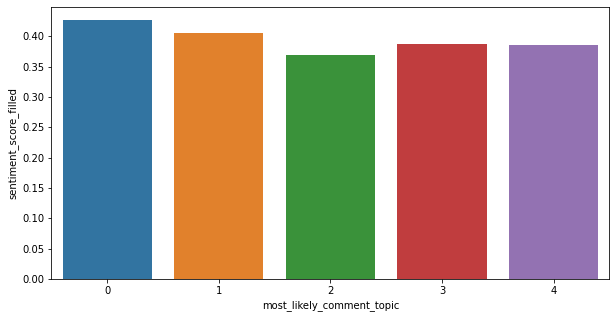

In [19]:
# by comment topic
plt.subplots(figsize=(10,5))
temp = comments_by_author.groupby('most_likely_comment_topic')['sentiment_score_filled'].mean().sort_values().reset_index()
sns.barplot(x='most_likely_comment_topic',y='sentiment_score_filled',data=temp)

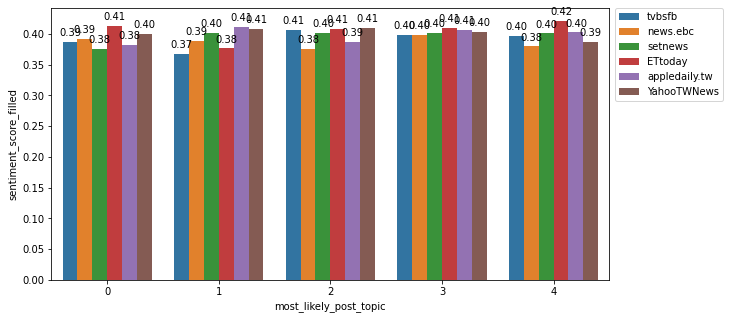

In [20]:
# by fanpage x post topic
plt.subplots(figsize=(10,5))
temp = comments_by_author.groupby(['fanpage','most_likely_post_topic'])['sentiment_score_filled'].mean().sort_values().reset_index()
plot = sns.barplot(x='most_likely_post_topic',y='sentiment_score_filled',hue="fanpage",data=temp)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

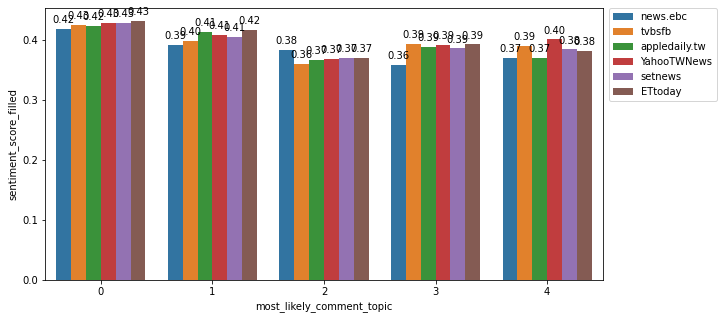

In [21]:
# by fanpage x comment topic
plt.subplots(figsize=(10,5))
temp = comments_by_author.groupby(['fanpage','most_likely_comment_topic'])['sentiment_score_filled'].mean().sort_values().reset_index()
plot = sns.barplot(x='most_likely_comment_topic',y='sentiment_score_filled',hue="fanpage",data=temp)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# 分階段

## 貼文

In [22]:
for phase in range(1,4):
    print(f"---------phase {phase}---------")
    num_topics = 5
    
    phase_posts = posts[posts['phase'] == phase]
    
    # prepare LDA configuration
    post_id2word = corpora.Dictionary(phase_posts['word_list']) # Create Dictionary
    post_texts = phase_posts['word_list'] # Create Corpus
    post_corpus = [post_id2word.doc2bow(post_texts) for post_texts in post_texts] # Term Document Frequency
    
    
    # Build LDA model
    post_lda_model = LdaMulticore(corpus=post_corpus,
                           id2word=post_id2word,
                           iterations=500,
                           num_topics=num_topics,
                           passes=10)

    # Print the Keyword in the 5 topics
    pprint(post_lda_model.print_topics())
    doc_lda = post_lda_model[post_corpus]
    

---------phase 1---------
[(0,
  '0.124*"振興券" + 0.027*"上路" + 0.018*"7月" + 0.017*"行政院" + 0.011*"方式" + '
  '0.011*"拍板" + 0.011*"政府" + 0.010*"紓困" + 0.010*"排富" + 0.010*"蘇貞昌"'),
 (1,
  '0.071*"消費券" + 0.044*"振興券" + 0.032*"馬英九" + 0.028*"紓困" + 0.021*"振興" + '
  '0.018*"發現金" + 0.016*"抵用券" + 0.016*"發放" + 0.013*"民眾" + 0.013*"武漢肺炎"'),
 (2,
  '0.059*"振興券" + 0.018*"振興" + 0.016*"消費" + 0.013*"抵用券" + 0.012*"消費券" + '
  '0.012*"當年" + 0.011*"武漢肺炎" + 0.009*"新冠肺炎" + 0.009*"藍委" + 0.007*"上路"'),
 (3,
  '0.070*"振興券" + 0.025*"消費券" + 0.017*"消費" + 0.012*"發放" + 0.011*"直接" + '
  '0.011*"經濟" + 0.011*"紓困" + 0.010*"政院" + 0.009*"經濟部" + 0.009*"不夠"'),
 (4,
  '0.051*"振興券" + 0.019*"消費" + 0.016*"消費券" + 0.015*"現金" + 0.012*"獨家" + '
  '0.012*"經濟" + 0.012*"明出爐" + 0.010*"發放" + 0.010*"抵用券" + 0.010*"觀光"')]
---------phase 2---------
[(0,
  '0.110*"三倍券" + 0.041*"振興" + 0.030*"懶人包" + 0.018*"信用" + 0.015*"上路" + '
  '0.014*"紙本" + 0.013*"優惠" + 0.013*"使用" + 0.010*"開放" + 0.010*"方式"'),
 (1,
  '0.057*"三倍券" + 0.017*"消費" + 0.016*"預購" + 0.016*"上路"

## 留言

In [23]:
%%time
for phase in range(1,4):
    print(f"---------phase {phase}---------")
    num_topics = 5
    
    phase_comments = comments_by_author[comments_by_author['phase'] == phase]
    
    # prepare LDA configuration
    comment_id2word = corpora.Dictionary(phase_comments['word_list'])
    comment_texts = phase_comments['word_list'] # Create Corpus
    comment_corpus = [comment_id2word.doc2bow(text) for text in comment_texts]# Term Document Frequency
    
    
    comment_lda_model = LdaMulticore(corpus=comment_corpus, id2word=comment_id2word, num_topics=num_topics)
    pprint(comment_lda_model.print_topics(num_words=3))
    doc_lda = comment_lda_model[comment_corpus]



---------phase 1---------
[(0, '0.038*"政府" + 0.021*"振興" + 0.021*"人民"'),
 (1, '0.022*"政府" + 0.018*"消費卷" + 0.017*"振興"'),
 (2, '0.020*"振興" + 0.016*"紓困" + 0.015*"發現金"'),
 (3, '0.026*"現金" + 0.020*"消費" + 0.017*"振興"'),
 (4, '0.014*"消費" + 0.013*"人民" + 0.011*"直接"')]
---------phase 2---------
[(0, '0.029*"振興" + 0.027*"政府" + 0.014*"消費"'),
 (1, '0.012*"政府" + 0.011*"政策" + 0.010*"民進黨"'),
 (2, '0.014*"麻煩" + 0.012*"政府" + 0.008*"消費"'),
 (3, '0.020*"政府" + 0.015*"現金" + 0.011*"人民"'),
 (4, '0.015*"振興" + 0.014*"政府" + 0.012*"消費"')]
---------phase 3---------
[(0, '0.017*"政府" + 0.012*"孩子" + 0.011*"人民"'),
 (1, '0.021*"政府" + 0.012*"小孩" + 0.009*"人民"'),
 (2, '0.009*"台灣" + 0.009*"現在" + 0.009*"振興"'),
 (3, '0.021*"小孩" + 0.012*"政府" + 0.012*"媽媽"'),
 (4, '0.016*"排隊" + 0.011*"小孩" + 0.010*"現在"')]
CPU times: user 10.7 s, sys: 1.81 s, total: 12.5 s
Wall time: 32.4 s
